In [26]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchmetrics import MeanAbsolutePercentageError
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks import ModelCheckpoint

import pytorch_lightning as pl

from sklearn.preprocessing import StandardScaler

from PIL import Image

import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import plotly.express as px
import mplfinance as mpf

In [27]:
if torch.cuda.is_available(): device = 'cuda'
elif torch.backends.mps.is_available(): device = 'mps'
else: device = 'cpu'  
device = torch.device("mps")

BATCH_SIZE = 64
EPOCHS = 3

### Data

In [29]:

def train_val_test_split(directory, filename):
    '''
    Split all data into training, validation, and testing feather files. 
    '''
    df = pd.read_feather(directory + filename + '.feather')
    df['year'] = df['filepath'].apply(lambda x: int(x.split('/')[-1].split('-')[0]))     # Parse year from filename

    # Train
    df_train = df[df['year'] <= 2020].head(1000).copy()

    # log_return_scaler = StandardScaler()
    # pct_return_scaler = StandardScaler()
    # df_train['log_returns'] = log_return_scaler.fit_transform(df_train['log_returns'].values.reshape(-1,1))
    # df_train['pct_returns'] = pct_return_scaler.fit_transform(df_train['pct_returns'].values.reshape(-1,1))

    train_path = directory + filename + '_train.feather'
    df_train.reset_index(drop=True).to_feather(train_path)

    # Validation
    df_val = df[df['year'] == 2021].head(100).copy()

    # df_val['log_returns'] = log_return_scaler.transform(df_val['log_returns'].values.reshape(-1,1))
    # df_val['pct_returns'] = pct_return_scaler.transform(df_val['pct_returns'].values.reshape(-1,1))

    val_path = directory + filename + '_val.feather'
    df_val.reset_index(drop=True).to_feather(val_path)

    # Test
    df_test = df[df['year'] == 2022].head(100).copy()

    # df_test['log_returns'] = log_return_scaler.transform(df_test['log_returns'].values.reshape(-1,1))
    # df_test['pct_returns'] = pct_return_scaler.transform(df_test['pct_returns'].values.reshape(-1,1))

    test_path = directory + filename + '_test.feather'
    df_test.reset_index(drop=True).to_feather(test_path)
    del df, df_train, df_val, df_test
    return train_path, val_path, test_path#, log_return_scaler, pct_return_scaler


class ChartTransform:
    def __init__(self):
        self.img_to_tensor = transforms.ToTensor()
        self.normalize_img = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    def __call__(self, sample):
        chart, label = sample

        chart = self.img_to_tensor(chart)
        chart = self.normalize_img(chart)

        label = torch.tensor(label, dtype=torch.float32)

        return chart, label


class ChartsDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.chart_metadata = pd.read_feather(data_path)
        self.n_samples = self.chart_metadata.shape[0]
        self.transform = transform

    def __getitem__(self, index):
        chart_path = self.chart_metadata.loc[index, 'filepath']
        chart = Image.open(chart_path).convert('RGB')

        # label = self.chart_metadata.loc[index, 'pct_returns']
        label = self.chart_metadata.loc[index, 'log_returns']

        if self.transform:
            chart, label = self.transform((chart, label))
            
        return chart, label

    def __len__(self):
        return self.n_samples


def train_val_test_ds_dl(train_path, val_path, test_path):
    '''
    Creates training, validation, and test Pytorch datasets and data loaders
    '''
    train_dataset = ChartsDataset(
        data_path=train_path,
        transform=ChartTransform()
    )
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0
    )

    val_dataset = ChartsDataset(
        data_path=val_path,
        transform=ChartTransform()
    )
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )

    test_dataset = ChartsDataset(
        data_path=test_path,
        transform=ChartTransform()
    )
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )
    return train_dataset, train_loader, val_dataset, val_loader, test_dataset, test_loader
        

### Model

In [30]:

class LitResnet(pl.LightningModule):
    def __init__(self, resnet, lr=1e-3):
        super().__init__()

        # Change the Resnet output to a single linear output
        resnet_num_feat = resnet.fc.in_features
        resnet.fc = nn.Linear(resnet_num_feat, 1)  
        self.resnet = resnet

        # RMSE loss function 
        self.criterion = self.__rmse

        self.lr = lr

    # def forward(self, x):
    #     return self.resnet(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self.resnet(x)
        pred = pred.view(-1) # reshape from N by 1 to N
        train_loss = self.criterion(pred, y)

        metrics = {
            'train_rmse_loss': train_loss,
            'train_rmae_loss': self.__rmae(pred, y),
            'train_mape_loss': self.__mape(pred, y)
        }
        self.log_dict(metrics, prog_bar=True)
        return train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self.resnet(x)
        pred = pred.view(-1) # reshape from N by 1 to N
        metrics = {
            'val_rmse_loss': self.criterion(pred, y),
            'val_rmae_loss': self.__rmae(pred, y),
            'val_mape_loss': self.__mape(pred, y)
        }
        self.log_dict(metrics, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        pred = self.resnet(x)
        pred = pred.view(-1) # reshape from N by 1 to N
        metrics = {
            'test_rmse_loss': self.criterion(pred, y),
            'test_rmae_loss': self.__rmae(pred, y),
            'test_mape_loss': self.__mape(pred, y)
        }
        self.log_dict(metrics, prog_bar=True)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        preds = self.resnet(x).cpu()
        return preds.numpy().reshape(-1)

    def configure_optimizers(self):
        # optim = torch.optim.Adam(self.parameters(), lr=1e-3)
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optim

    def __rmse(self, y_hat, y):
        criterion = nn.MSELoss()
        mse = criterion(y_hat, y)
        rmse = torch.sqrt(mse)
        return rmse

    def __rmae(self, y_hat, y):
        criterion = nn.L1Loss()
        mae = criterion(y_hat, y)
        rmae = torch.sqrt(mae)
        return rmae

    def __mape(self, y_hat, y):
        criterion = MeanAbsolutePercentageError().to(device)
        mape = criterion(y_hat, y)
        return mape


class TrainHist(Callback):
    '''
    Custom callback to record regression metrics at the end of each epoch
    '''
    def __init__(self):
        self.train_epoch_hist = []
        self.val_epoch_hist = []

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_train_hist = trainer.logged_metrics        
        self.train_epoch_hist.append(epoch_train_hist)

    def on_validation_epoch_end(self, trainer, pl_module):
        epoch_val_hist = trainer.logged_metrics        
        self.val_epoch_hist.append(epoch_val_hist)

    def get_hist_df(self):
        temp = []
        for e in self.val_epoch_hist:
            temp_dict = {}
            for key, value in e.items():
                temp_dict[key] = value.item()
            temp.append(temp_dict)

        df = pd.DataFrame(temp)
        df['epoch'] = df.index
        return df



In [37]:
def train_resnet(data_dir, data_file, resnet, cpt_path, callbacks=[TrainHist()]):
    train_path, val_path, test_path = train_val_test_split(data_dir, data_file)
    train_dataset, train_loader, val_dataset, val_loader, test_dataset, test_loader = train_val_test_ds_dl(train_path, val_path, test_path)

    model = LitResnet(resnet=resnet)

    trainer = pl.Trainer(
        max_epochs=EPOCHS,
        auto_lr_find=True,
        accelerator='gpu', 
        devices=-1,
        callbacks=callbacks,
        default_root_dir=cpt_path,
    )

    trainer.tune(
        model=model,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader
    )

    trainer.fit(    
        model=model,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader
    )

    test_set_predictions = np.concatenate(trainer.predict(model, test_loader))
    test_set_metrics = trainer.test(model=model, dataloaders=test_loader)

    return test_set_predictions, test_set_metrics


### 1 Minute Prediciton

#### Resnet-18

In [38]:
min1_resnet18_checkpoint_callback = ModelCheckpoint(
    save_top_k=-1,
    monitor='val_rmse_loss',
    every_n_epochs=1,
    dirpath='model_training_logs/1min_pred/resnet18/',
    filename='sample-mnist-{epoch:03d}-{val_rmse_loss:.5f}',
)


min1_pred_dir, min1_pred_filename = 'data/chart_metadata/30min_features/1min_prediction/', 'pgco30_chartmetadata'
train_path, val_path, test_path = train_val_test_split(min1_pred_dir, min1_pred_filename)
train_dataset, train_loader, val_dataset, val_loader, test_dataset, test_loader = train_val_test_ds_dl(train_path, val_path, test_path)

resnet = models.resnet18(weights=None)
train_hist = TrainHist()

res_1min_resnet18_preds, res_1min_resnet18_metrics = train_resnet(min1_pred_dir, min1_pred_filename, resnet, callbacks=[train_hist, min1_resnet18_checkpoint_callback], cpt_path='model_training_logs/1min_pred/resnet18/')

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: model_training_logs/1min_pred/resnet18/lightning_logs
/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/model_training_logs/1min_pred/resnet18 exists and is not empty.
/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 whi

Epoch 2: 100%|██████████| 18/18 [00:01<00:00,  9.09it/s, loss=1.73, v_num=0, train_rmse_loss=2.190, train_rmae_loss=1.190, train_mape_loss=2.04e+4, val_rmse_loss=0.322, val_rmae_loss=0.518, val_mape_loss=5.44e+4]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 18/18 [00:02<00:00,  8.38it/s, loss=1.73, v_num=0, train_rmse_loss=2.190, train_rmae_loss=1.190, train_mape_loss=2.04e+4, val_rmse_loss=0.322, val_rmae_loss=0.518, val_mape_loss=5.44e+4]


/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 27.20it/s]


/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 26.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_mape_loss          11301.6943359375
     test_rmae_loss         1.0005525350570679
     test_rmse_loss         1.4202706813812256
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


#### ResNet-50

In [7]:
min1_resnet50_checkpoint_callback = ModelCheckpoint(
    save_top_k=-1,
    monitor='val_rmse_loss',
    every_n_epochs=1,
    dirpath='model_training_logs/1min_pred/resnet50/',
    filename='sample-mnist-{epoch:03d}-{val_rmse_loss:.5f}',
)

resnet = models.resnet50(weights=None)
res_1min_resnet50_preds, res_1min_resnet50_metrics = train_resnet(min1_pred_dir, min1_pred_filename, resnet, callbacks=[train_hist, min1_resnet50_checkpoint_callback], cpt_path='model_training_logs/1min_pred/resnet50/')

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: model_training_logs/1min_pred/resnet50/lightning_logs
/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(l

Epoch 2: 100%|██████████| 18/18 [00:03<00:00,  4.62it/s, loss=1.65, v_num=0, train_rmse_loss=1.280, train_rmae_loss=0.880, train_mape_loss=2.52e+4, val_rmse_loss=0.302, val_rmae_loss=0.457, val_mape_loss=2.23e+4]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 18/18 [00:04<00:00,  4.20it/s, loss=1.65, v_num=0, train_rmse_loss=1.280, train_rmae_loss=0.880, train_mape_loss=2.52e+4, val_rmse_loss=0.302, val_rmae_loss=0.457, val_mape_loss=2.23e+4]


/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 14.81it/s]


/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 14.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_mape_loss           5047.8994140625
     test_rmae_loss         0.9717299938201904
     test_rmse_loss         1.3935961723327637
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


#### ResNet-152

In [9]:
min1_resnet152_checkpoint_callback = ModelCheckpoint(
    save_top_k=-1,
    monitor='val_rmse_loss',
    every_n_epochs=1,
    dirpath='model_training_logs/1min_pred/resnet152/',
    filename='sample-mnist-{epoch:03d}-{val_rmse_loss:.5f}',
)

resnet = models.resnet152(weights=None)
res_1min_resnet152_preds, res_1min_resnet152_metrics = train_resnet(min1_pred_dir, min1_pred_filename, resnet, callbacks=[train_hist, min1_resnet152_checkpoint_callback], cpt_path='model_training_logs/1min_pred/resnet152/')

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: model_training_logs/1min_pred/resnet152/lightning_logs
/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(

Epoch 2: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s, loss=1.77, v_num=0, train_rmse_loss=1.630, train_rmae_loss=1.130, train_mape_loss=1.32e+5, val_rmse_loss=0.663, val_rmae_loss=0.772, val_mape_loss=1.27e+5]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 18/18 [00:10<00:00,  1.72it/s, loss=1.77, v_num=0, train_rmse_loss=1.630, train_rmae_loss=1.130, train_mape_loss=1.32e+5, val_rmse_loss=0.663, val_rmae_loss=0.772, val_mape_loss=1.27e+5]


/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]


/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  8.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_mape_loss           33386.10546875
     test_rmae_loss         1.0347765684127808
     test_rmse_loss          1.491937279701233
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### 5 Minute Prediction

#### Resnet-18

In [10]:
min5_resnet18_checkpoint_callback = ModelCheckpoint(
    save_top_k=-1,
    monitor='val_rmse_loss',
    every_n_epochs=1,
    dirpath='model_training_logs/5min_pred/resnet18/',
    filename='sample-mnist-{epoch:03d}-{val_rmse_loss:.5f}',
)

min5_pred_dir, min5_pred_filename = 'data/chart_metadata/30min_features/5min_prediction/', 'pgco30_chartmetadata'
train_path, val_path, test_path = train_val_test_split(min5_pred_dir, min5_pred_filename)
train_dataset, train_loader, val_dataset, val_loader, test_dataset, test_loader = train_val_test_ds_dl(train_path, val_path, test_path)

resnet = models.resnet18(weights=None)
train_hist = TrainHist()

res_5min_resnet18_preds, res_5min_resnet18_metrics = train_resnet(min5_pred_dir, min5_pred_filename, resnet, callbacks=[train_hist, min5_resnet18_checkpoint_callback], cpt_path='model_training_logs/5min_pred/resnet18/')

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: model_training_logs/5min_pred/resnet18/lightning_logs
/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(l

Epoch 2: 100%|██████████| 18/18 [00:01<00:00,  9.52it/s, loss=3.64, v_num=0, train_rmse_loss=3.500, train_rmae_loss=1.630, train_mape_loss=6.83e+3, val_rmse_loss=0.771, val_rmae_loss=0.793, val_mape_loss=1.21e+4]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 18/18 [00:02<00:00,  8.78it/s, loss=3.64, v_num=0, train_rmse_loss=3.500, train_rmae_loss=1.630, train_mape_loss=6.83e+3, val_rmse_loss=0.771, val_rmae_loss=0.793, val_mape_loss=1.21e+4]


/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 39.47it/s]


/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 33.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_mape_loss             12496.46875
     test_rmae_loss         1.5129265785217285
     test_rmse_loss         3.2431774139404297
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


#### ResNet-50

In [11]:
min5_resnet50_checkpoint_callback = ModelCheckpoint(
    save_top_k=-1,
    monitor='val_rmse_loss',
    every_n_epochs=1,
    dirpath='model_training_logs/5min_pred/resnet50/',
    filename='sample-mnist-{epoch:03d}-{val_rmse_loss:.5f}',
)

resnet = models.resnet50(weights=None)
res_5min_resnet50_preds, res_5min_resnet50_metrics = train_resnet(min5_pred_dir, min5_pred_filename, resnet, callbacks=[train_hist, min5_resnet50_checkpoint_callback], cpt_path='model_training_logs/5min_pred/resnet50/')

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: model_training_logs/5min_pred/resnet50/lightning_logs
/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(l

Epoch 2: 100%|██████████| 18/18 [00:03<00:00,  4.58it/s, loss=3.58, v_num=0, train_rmse_loss=3.810, train_rmae_loss=1.570, train_mape_loss=1.080, val_rmse_loss=0.537, val_rmae_loss=0.603, val_mape_loss=2.51e+3]  

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 18/18 [00:04<00:00,  4.18it/s, loss=3.58, v_num=0, train_rmse_loss=3.810, train_rmae_loss=1.570, train_mape_loss=1.080, val_rmse_loss=0.537, val_rmae_loss=0.603, val_mape_loss=2.51e+3]


/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 17.44it/s]


/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 16.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_mape_loss          2420.00830078125
     test_rmae_loss         1.4966939687728882
     test_rmse_loss         3.1902923583984375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


#### ResNet-152

In [12]:
min5_resnet152_checkpoint_callback = ModelCheckpoint(
    save_top_k=-1,
    monitor='val_rmse_loss',
    every_n_epochs=1,
    dirpath='model_training_logs/5min_pred/resnet152/',
    filename='sample-mnist-{epoch:03d}-{val_rmse_loss:.5f}',
)

resnet = models.resnet152(weights=None)
res_5min_resnet152_preds, res_5min_resnet152_metrics = train_resnet(min5_pred_dir, min5_pred_filename, resnet, callbacks=[train_hist, min5_resnet152_checkpoint_callback], cpt_path='model_training_logs/5min_pred/resnet152/')

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: model_training_logs/5min_pred/resnet152/lightning_logs
/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(

Epoch 2: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s, loss=3.66, v_num=0, train_rmse_loss=4.280, train_rmae_loss=1.790, train_mape_loss=6.37e+3, val_rmse_loss=0.513, val_rmae_loss=0.610, val_mape_loss=5.4e+3] 

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 18/18 [00:10<00:00,  1.77it/s, loss=3.66, v_num=0, train_rmse_loss=4.280, train_rmae_loss=1.790, train_mape_loss=6.37e+3, val_rmse_loss=0.513, val_rmae_loss=0.610, val_mape_loss=5.4e+3]


/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]


/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  8.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_mape_loss           4780.4052734375
     test_rmae_loss         1.5169472694396973
     test_rmse_loss         3.2281603813171387
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### 10 Minute Prediction

#### ResNet-18

In [13]:
min10_resnet18_checkpoint_callback = ModelCheckpoint(
    save_top_k=-1,
    monitor='val_rmse_loss',
    every_n_epochs=1,
    dirpath='model_training_logs/10min_pred/resnet18/',
    filename='sample-mnist-{epoch:03d}-{val_rmse_loss:.5f}',
)

min10_pred_dir, min10_pred_filename = 'data/chart_metadata/30min_features/10min_prediction/', 'pgco30_chartmetadata'
train_path, val_path, test_path = train_val_test_split(min10_pred_dir, min10_pred_filename)
train_dataset, train_loader, val_dataset, val_loader, test_dataset, test_loader = train_val_test_ds_dl(train_path, val_path, test_path)

resnet = models.resnet18(weights=None)
train_hist = TrainHist()

res_10min_resnet18_preds, res_10min_resnet18_metrics = train_resnet(min10_pred_dir, min10_pred_filename, resnet, callbacks=[train_hist, min10_resnet18_checkpoint_callback], cpt_path='model_training_logs/10min_pred/resnet18/')

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: model_training_logs/10min_pred/resnet18/lightning_logs
/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(

Epoch 2: 100%|██████████| 18/18 [00:02<00:00,  8.97it/s, loss=4.96, v_num=0, train_rmse_loss=4.330, train_rmae_loss=1.700, train_mape_loss=77.50, val_rmse_loss=0.500, val_rmae_loss=0.578, val_mape_loss=8.36e+3]  

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 18/18 [00:02<00:00,  8.27it/s, loss=4.96, v_num=0, train_rmse_loss=4.330, train_rmae_loss=1.700, train_mape_loss=77.50, val_rmse_loss=0.500, val_rmae_loss=0.578, val_mape_loss=8.36e+3]


/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 29.62it/s]


/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 24.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_mape_loss         0.9888173937797546
     test_rmae_loss          1.837289571762085
     test_rmse_loss          4.527030944824219
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


#### ResNet-50

In [14]:
min10_resnet50_checkpoint_callback = ModelCheckpoint(
    save_top_k=-1,
    monitor='val_rmse_loss',
    every_n_epochs=1,
    dirpath='model_training_logs/10min_pred/resnet50/',
    filename='sample-mnist-{epoch:03d}-{val_rmse_loss:.5f}',
)

resnet = models.resnet50(weights=None)
res_10min_resnet50_preds, res_10min_resnet50_metrics = train_resnet(min10_pred_dir, min10_pred_filename, resnet, callbacks=[train_hist, min10_resnet50_checkpoint_callback], cpt_path='model_training_logs/10min_pred/resnet50/')

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: model_training_logs/10min_pred/resnet50/lightning_logs
/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(

Epoch 2: 100%|██████████| 18/18 [00:03<00:00,  4.55it/s, loss=4.94, v_num=0, train_rmse_loss=5.050, train_rmae_loss=1.980, train_mape_loss=4.510, val_rmse_loss=0.617, val_rmae_loss=0.698, val_mape_loss=2.44e+4]  

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 18/18 [00:04<00:00,  4.18it/s, loss=4.94, v_num=0, train_rmse_loss=5.050, train_rmae_loss=1.980, train_mape_loss=4.510, val_rmse_loss=0.617, val_rmae_loss=0.698, val_mape_loss=2.44e+4]


/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 18.63it/s]


/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 16.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_mape_loss         1.1355034112930298
     test_rmae_loss         1.8590905666351318
     test_rmse_loss          4.543346881866455
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


#### ResNet-152

In [15]:
min10_resnet152_checkpoint_callback = ModelCheckpoint(
    save_top_k=-1,
    monitor='val_rmse_loss',
    every_n_epochs=1,
    dirpath='model_training_logs/10min_pred/resnet152/',
    filename='sample-mnist-{epoch:03d}-{val_rmse_loss:.5f}',
)

resnet = models.resnet152(weights=None)
res_10min_resnet152_preds, res_10min_resnet152_metrics = train_resnet(min10_pred_dir, min10_pred_filename, resnet, callbacks=[train_hist, min10_resnet152_checkpoint_callback], cpt_path='model_training_logs/10min_pred/resnet152/')

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: model_training_logs/10min_pred/resnet152/lightning_logs
/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer

Epoch 2: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s, loss=4.95, v_num=0, train_rmse_loss=6.070, train_rmae_loss=2.100, train_mape_loss=4.7e+3, val_rmse_loss=0.549, val_rmae_loss=0.613, val_mape_loss=7.68e+3] 

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 18/18 [00:10<00:00,  1.78it/s, loss=4.95, v_num=0, train_rmse_loss=6.070, train_rmae_loss=2.100, train_mape_loss=4.7e+3, val_rmse_loss=0.549, val_rmae_loss=0.613, val_mape_loss=7.68e+3]


/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  9.43it/s]


/Users/adammiyauchi/Documents/Arizona State University/Masters/Semester 1/CSE572 - Data Minning/Project/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  8.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_mape_loss         0.9926867485046387
     test_rmae_loss         1.8447561264038086
     test_rmse_loss          4.529992580413818
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Evaluations

In [16]:
min1_test = pd.read_feather('data/chart_metadata/30min_features/1min_prediction/pgco30_chartmetadata_test.feather')
min5_test = pd.read_feather('data/chart_metadata/30min_features/5min_prediction/pgco30_chartmetadata_test.feather')
min10_test = pd.read_feather('data/chart_metadata/30min_features/10min_prediction/pgco30_chartmetadata_test.feather')


predictions = pd.DataFrame({
    '1min_y': min1_test['log_returns'], '1min_resnet18_preds': res_1min_resnet18_preds, '1min_resnet50_preds': res_1min_resnet50_preds, '1min_resnet152_preds': res_1min_resnet152_preds,
    '5min_y': min5_test['log_returns'], '5min_resnet18_preds': res_5min_resnet18_preds, '5min_resnet50_preds': res_5min_resnet50_preds, '5min_resnet152_preds': res_5min_resnet152_preds,
    '10min_y': min10_test['log_returns'], '10min_resnet18_preds': res_10min_resnet18_preds, '10min_resnet50_preds': res_10min_resnet50_preds, '10min_resnet152_preds': res_10min_resnet152_preds,
})
predictions['1min_naive'] = predictions['1min_y'].shift(periods=1, fill_value=0)
predictions['5min_naive'] = predictions['5min_y'].shift(periods=1, fill_value=0)
predictions['10min_naive'] = predictions['10min_y'].shift(periods=1, fill_value=0)
predictions.to_csv('evaluations/model_predictions.csv', index=False)


In [17]:
mse, mae, mape = nn.MSELoss(), nn.L1Loss(), MeanAbsolutePercentageError().to(device)
naive_results = pd.DataFrame({
    'test_rmse_loss': [torch.sqrt(mse(torch.tensor(predictions['1min_y']), torch.tensor(predictions['1min_naive']))).item(), torch.sqrt(mse(torch.tensor(predictions['5min_y']), torch.tensor(predictions['5min_naive']))).item(), torch.sqrt(mse(torch.tensor(predictions['10min_y']), torch.tensor(predictions['10min_naive']))).item()],
    'test_rmae_loss': [torch.sqrt(mae(torch.tensor(predictions['1min_y']), torch.tensor(predictions['1min_naive']))).item(), torch.sqrt(mae(torch.tensor(predictions['5min_y']), torch.tensor(predictions['5min_naive']))).item(), torch.sqrt(mae(torch.tensor(predictions['10min_y']), torch.tensor(predictions['10min_naive']))).item()],
    'test_mape_loss': [mae(torch.tensor(predictions['1min_y']), torch.tensor(predictions['1min_naive'])).item(), mae(torch.tensor(predictions['5min_y']), torch.tensor(predictions['5min_naive'])).item(), mae(torch.tensor(predictions['10min_y']), torch.tensor(predictions['10min_naive'])).item()],
    'prediction_horizon': ['1 Minute', '5 Minute', '10 Minute'],
    'resnet_type': ['Naive', 'Naive', 'Naive']
})

In [18]:
metrics = [
    res_1min_resnet18_metrics, res_1min_resnet50_metrics, res_1min_resnet152_metrics,
    res_5min_resnet18_metrics, res_5min_resnet50_metrics, res_5min_resnet152_metrics,
    res_10min_resnet18_metrics, res_10min_resnet50_metrics, res_10min_resnet152_metrics
]
metrics = [metric[0] for metric in metrics]
prediction_horizon = ['1 Minute', '1 Minute', '1 Minute', '5 Minute', '5 Minute', '5 Minute', '10 Minute', '10 Minute', '10 Minute']
resnet_type = ['ResNet-18', 'ResNet-50', 'ResNet-152', 'ResNet-18', 'ResNet-50', 'ResNet-152', 'ResNet-18', 'ResNet-50', 'ResNet-152']
metrics = pd.DataFrame(metrics)
metrics['prediction_horizon'] = pd.Categorical(prediction_horizon)
metrics['resnet_type'] = pd.Categorical(resnet_type)

metrics = pd.concat([metrics, naive_results])

metrics.to_csv('evaluations/accuracy_metrics.csv', index=False)
metrics

,test_rmse_loss,test_rmae_loss,test_mape_loss,prediction_horizon,resnet_type
0,1.407027,0.978031,12548.919922,1 Minute,ResNet-18
1,1.393596,0.971730,5047.899414,1 Minute,ResNet-50
2,1.491937,1.034777,33386.105469,1 Minute,ResNet-152
3,3.243177,1.512927,12496.468750,5 Minute,ResNet-18
4,3.190292,1.496694,2420.008301,5 Minute,ResNet-50
5,3.228160,1.516947,4780.405273,5 Minute,ResNet-152
6,4.527031,1.837290,0.988817,10 Minute,ResNet-18
7,4.543347,1.859091,1.135503,10 Minute,ResNet-50
8,4.529993,1.844756,0.992687,10 Minute,ResNet-152
0,1.942606,1.162518,1.351449,1 Minute,Naive


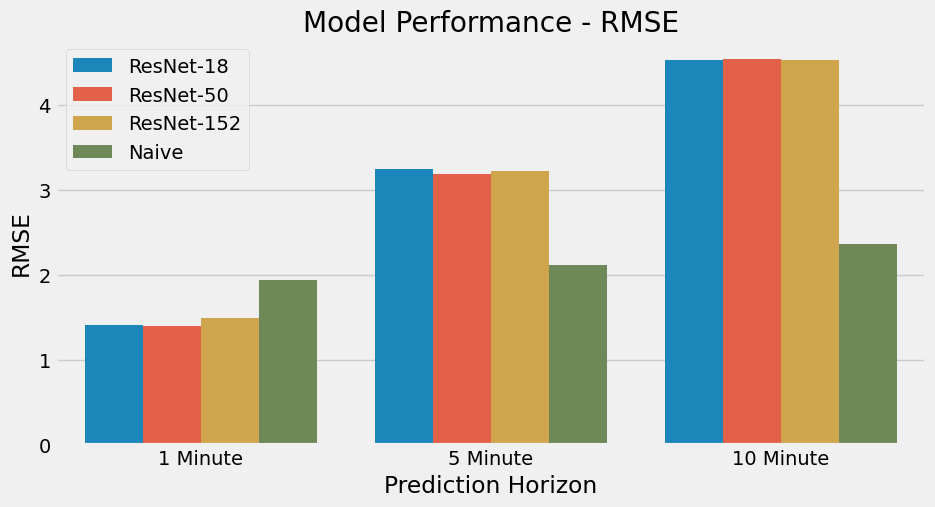

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
g = sns.barplot(
    data=metrics, x='prediction_horizon', y='test_rmse_loss', hue='resnet_type',
).set(
    title='Model Performance - RMSE',
    xlabel='Prediction Horizon',
    ylabel='RMSE',
)
_ = plt.legend(title='')
plt.savefig('evaluations/resnet_model_rmse_performance_grouped_bar.png', dpi=fig.dpi)

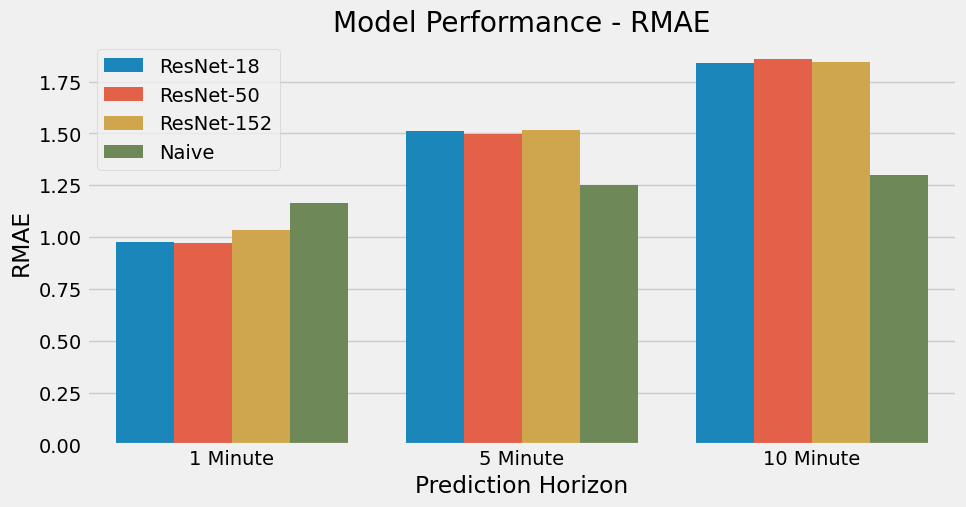

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
g = sns.barplot(
    data=metrics, x='prediction_horizon', y='test_rmae_loss', hue='resnet_type',
).set(
    title='Model Performance - RMAE',
    xlabel='Prediction Horizon',
    ylabel='RMAE',
)
_ = plt.legend(title='')
plt.savefig('evaluations/resnet_model_rmae_performance_grouped_bar.png', dpi=fig.dpi)

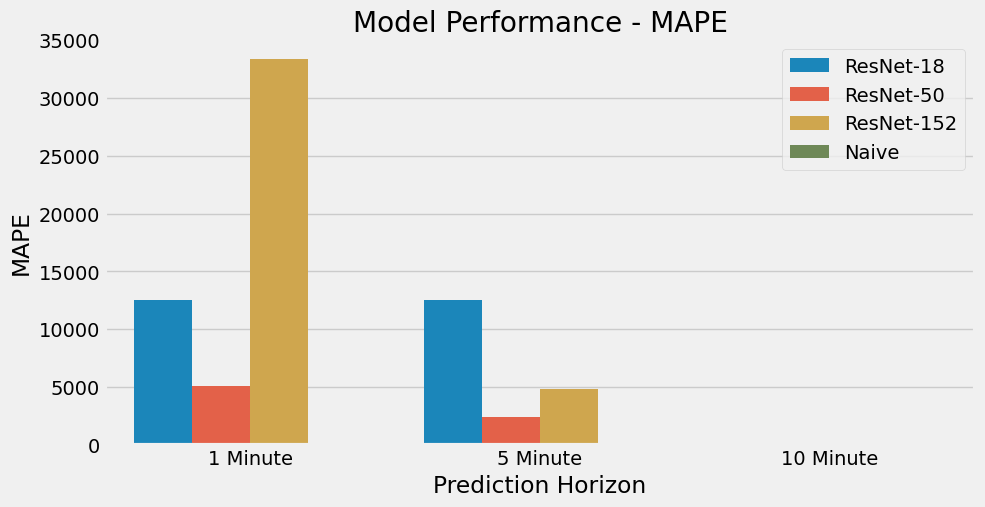

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
g = sns.barplot(
    data=metrics, x='prediction_horizon', y='test_mape_loss', hue='resnet_type',
).set(
    title='Model Performance - MAPE',
    xlabel='Prediction Horizon',
    ylabel='MAPE',
)
_ = plt.legend(title='')
plt.savefig('evaluations/resnet_model_mape_performance_grouped_bar.png', dpi=fig.dpi)

In [ ]:
# temp = pd.read_feather('data/chart_metadata/30min_features/1min_prediction/pgco30_chartmetadata_test.feather')
# temp['date'] = temp['filepath'].apply(lambda x: x.split('/')[-1].split('_')[0])
# temp['symbol'] = temp['filepath'].apply(lambda x: x.split('/')[-1].split('_')[1])
# temp = temp[(temp['date'] == '2022-01-07') & (temp['symbol'] == 'ABSI')]

# temp['filepath'][0]

# # 2022-01-07_ABSI_050100_053400 -- 5:35
# # 2022-01-07_ABSI_064400_071300 -- 7:14

In [ ]:
# predictions

In [22]:
pd.set_option('display.max_columns', 3000)
absi = pd.read_feather('data/minute_data/mover_d1_pgco30_2013_2022.feather')
absi = absi[(absi['date'] == datetime(2022,1,7).date()) & (absi['symbol'] == 'ABSI') & (absi['time'] >= datetime(2000,1,1,5,35).time()) & (absi['time'] <= datetime(2000,1,1,7,14).time())]
absi = absi.set_index('datetime')

# Testing
# absi['log_return'] = np.log(absi['close'] / absi['open']) * 100
# absi['naive1'] = absi['log_return'].shift(periods=1)
# absi = absi[1:]

# 1 min predictions
absi['naive1'] = predictions['1min_naive'].values
absi['naive1_pred'] = absi['open'].values * (np.exp(1) ** (absi['naive1']/100))

absi['1min_resnet18'] = predictions['1min_resnet18_preds'].values
absi['1min_resnet18_pred'] = absi['open'].values * (np.exp(1) ** (absi['1min_resnet18']/100))

absi['1min_resnet50'] = predictions['1min_resnet50_preds'].values
absi['1min_resnet50_pred'] = absi['open'].values * (np.exp(1) ** (absi['1min_resnet50']/100))

absi['1min_resnet152'] = predictions['1min_resnet152_preds'].values
absi['1min_resnet152_pred'] = absi['open'].values * (np.exp(1) ** (absi['1min_resnet152']/100))

# 5 min predictions
absi['naive5'] = predictions['5min_naive'].values
absi['naive5_pred'] = absi['open'].values * (np.exp(1) ** (absi['naive5']/100))
absi['naive5_pred'] = absi['naive5_pred'].shift(periods=4)

absi['5min_resnet18'] = predictions['5min_resnet18_preds'].values
absi['5min_resnet18_pred'] = absi['open'].values * (np.exp(1) ** (absi['5min_resnet18']/100))

absi['5min_resnet50'] = predictions['5min_resnet50_preds'].values
absi['5min_resnet50_pred'] = absi['open'].values * (np.exp(1) ** (absi['5min_resnet50']/100))

absi['5min_resnet152'] = predictions['5min_resnet152_preds'].values
absi['5min_resnet152_pred'] = absi['open'].values * (np.exp(1) ** (absi['5min_resnet152']/100))

# 10 min predictions
absi['naive10'] = predictions['10min_naive'].values
absi['naive10_pred'] = absi['open'].values * (np.exp(1) ** (absi['naive10']/100))
absi['naive10_pred'] = absi['naive10_pred'].shift(periods=9)

absi['10min_resnet18'] = predictions['10min_resnet18_preds'].values
absi['10min_resnet18_pred'] = absi['open'].values * (np.exp(1) ** (absi['10min_resnet18']/100))

absi['10min_resnet50'] = predictions['10min_resnet50_preds'].values
absi['10min_resnet50_pred'] = absi['open'].values * (np.exp(1) ** (absi['10min_resnet50']/100))

absi['10min_resnet152'] = predictions['10min_resnet152_preds'].values
absi['10min_resnet152_pred'] = absi['open'].values * (np.exp(1) ** (absi['10min_resnet152']/100))


# absi['naive1'] = predictions['1min_naive'].values
# absi['pred_price'] = absi['open'].values * (np.exp(1) ** absi['naive1'])
absi.head()

,id,symbol,close,high,low,trades,open,volume,vwap,time,date,naive1,naive1_pred,1min_resnet18,1min_resnet18_pred,1min_resnet50,1min_resnet50_pred,1min_resnet152,1min_resnet152_pred,naive5,naive5_pred,5min_resnet18,5min_resnet18_pred,5min_resnet50,5min_resnet50_pred,5min_resnet152,5min_resnet152_pred,naive10,naive10_pred,10min_resnet18,10min_resnet18_pred,10min_resnet50,10min_resnet50_pred,10min_resnet152,10min_resnet152_pred
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-07 05:35:00,1d5b36b3-bf63-4b29-98d7-3100054d7921,ABSI,8.78,8.93,8.78,110,8.93,6942,8.8567,05:35:00,2022-01-07,0.000000,8.930000,-0.290025,8.904138,-0.169914,8.914839,-0.365147,8.897452,0.000000,NaN,-0.252687,8.907464,0.018674,8.931668,0.213659,8.949100,0.000000,NaN,0.047243,8.934220,0.592180,8.983039,-0.037056,8.926691
2022-01-07 05:36:00,8f9f2ea4-a87b-4730-a414-93896a9f6cf0,ABSI,8.80,8.80,8.64,151,8.75,8914,8.7098,05:36:00,2022-01-07,-1.693999,8.603024,-0.322584,8.721820,-0.165264,8.735551,-0.650781,8.693242,0.558349,NaN,-0.492090,8.707048,0.082647,8.757235,0.176645,8.765470,1.555587,NaN,-0.159409,8.736063,0.566653,8.799723,0.089741,8.757855
2022-01-07 05:37:00,d55ed562-a8a1-47c6-9c69-bd493120e857,ABSI,8.87,8.87,8.75,50,8.75,3520,8.8083,05:37:00,2022-01-07,0.569802,8.800000,-0.159434,8.736061,0.106175,8.759295,-0.616186,8.696249,8.118491,NaN,-0.442344,8.711380,0.018827,8.751647,0.174893,8.765317,2.817088,NaN,-0.057864,8.744938,0.112110,8.759815,0.194934,8.767073
2022-01-07 05:38:00,191b0dc9-9efc-47a4-81ab-3675054390e0,ABSI,8.93,9.05,8.88,101,8.89,10377,8.9209,05:38:00,2022-01-07,1.362110,9.011920,-0.359038,8.858139,-0.044075,8.886083,-0.590756,8.837637,7.059159,NaN,-0.460116,8.849190,-0.118930,8.879434,0.008346,8.890742,2.371653,NaN,0.122738,8.900918,0.354979,8.921614,0.145646,8.902958
2022-01-07 05:39:00,b0625e6b-75d6-41ab-b7d7-7e67e7ffb084,ABSI,8.98,9.05,8.98,118,8.99,8467,8.9949,05:39:00,2022-01-07,0.448935,9.030450,-0.138945,8.977517,-0.042137,8.986213,-0.874677,8.911709,3.101024,8.93,-0.573052,8.938630,-0.024996,8.987753,0.370310,9.023352,0.224719,NaN,0.096633,8.998691,0.330059,9.019721,0.114988,9.000343


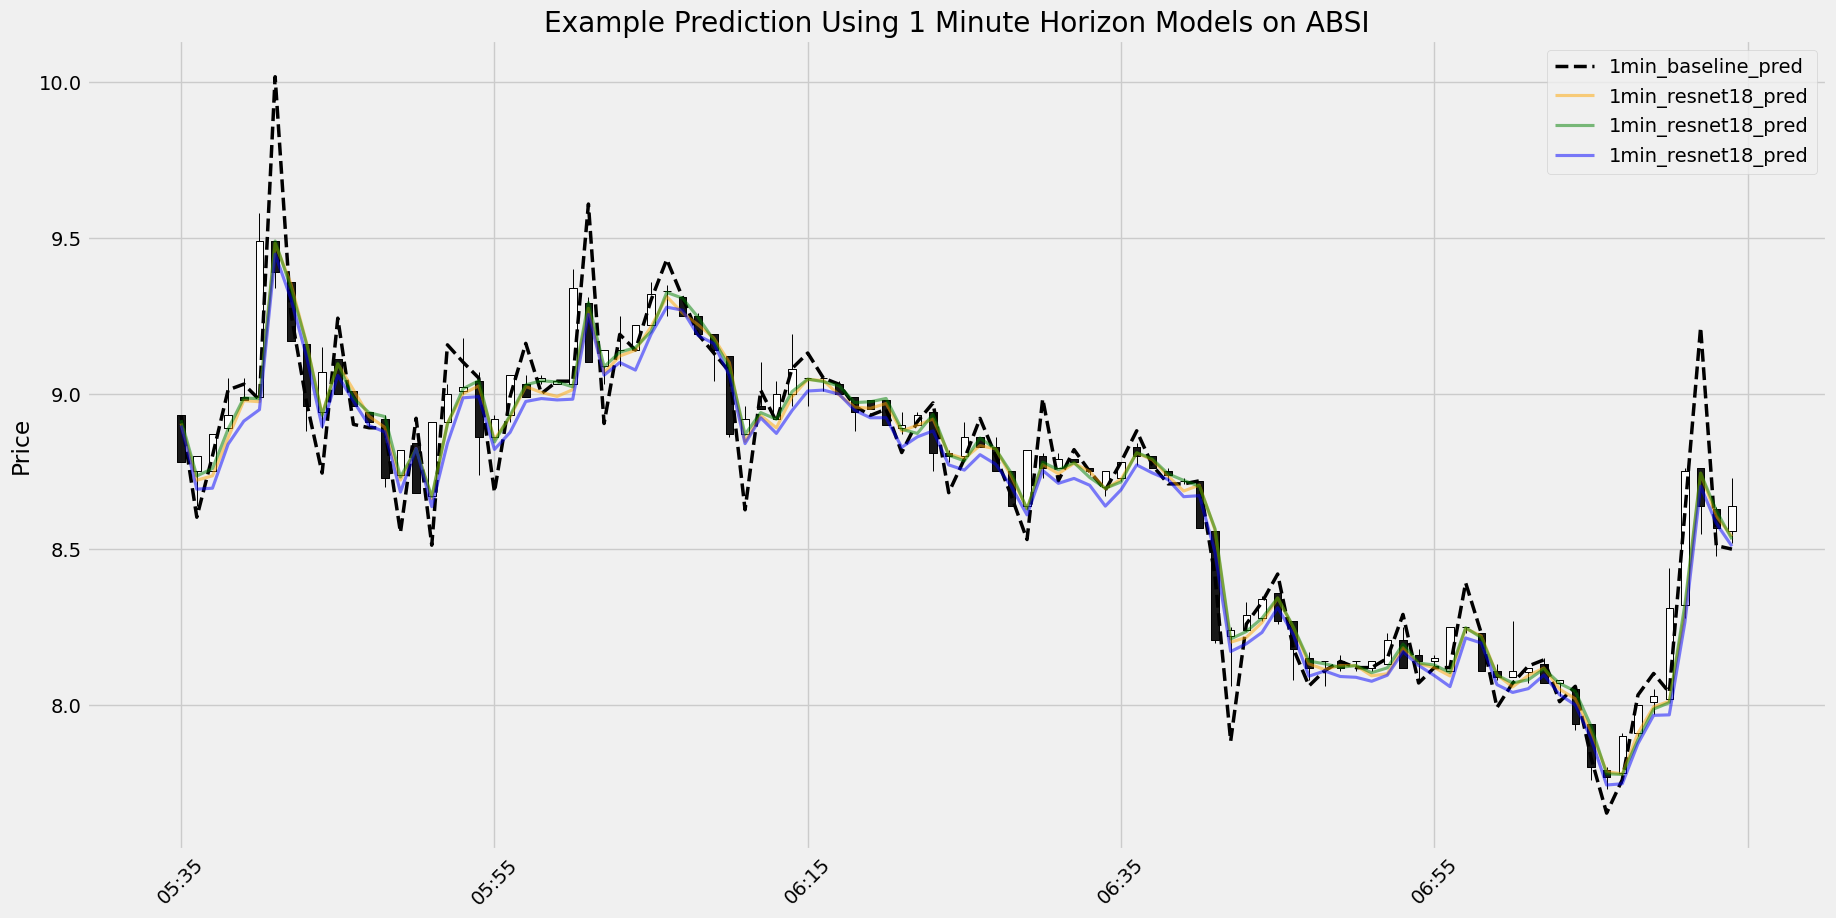

In [23]:
fig, ax = plt.subplots(figsize=(20,10))
mpf.plot(absi, type='candle', ax=ax)
ax.plot(absi['naive1_pred'].values, c='black', linestyle='--', linewidth=2.5, label='1min_baseline_pred')
ax.plot(absi['1min_resnet18_pred'].values, c='orange', alpha=0.5, linewidth=2.25, label='1min_resnet18_pred')
ax.plot(absi['1min_resnet50_pred'].values, c='green', alpha=0.5, linewidth=2.25, label='1min_resnet18_pred')
ax.plot(absi['1min_resnet152_pred'].values, c='blue', alpha=0.5, linewidth=2.25, label='1min_resnet18_pred')
plt.legend()
plt.title('Example Prediction Using 1 Minute Horizon Models on ABSI')
plt.savefig('evaluations/absi_prediction_1min_models.png', dpi=fig.dpi)

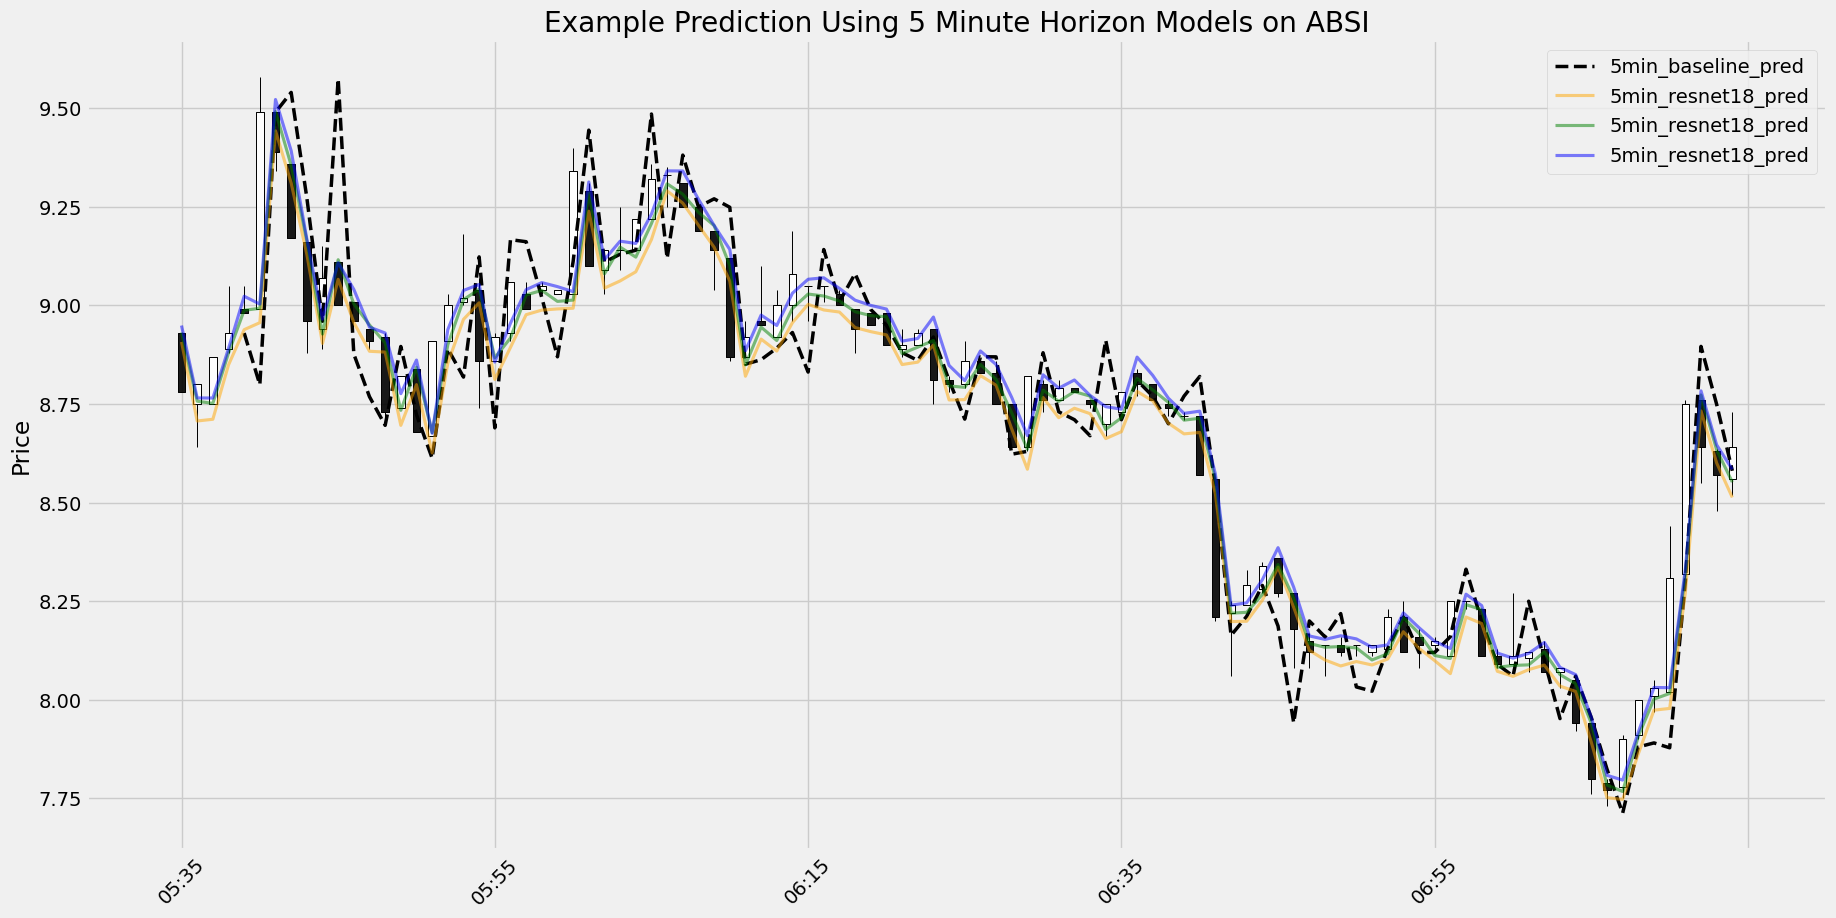

In [24]:
fig, ax = plt.subplots(figsize=(20,10))
mpf.plot(absi, type='candle', ax=ax)
ax.plot(absi['naive5_pred'].values, c='black', linestyle='--', linewidth=2.5, label='5min_baseline_pred')
ax.plot(absi['5min_resnet18_pred'].values, c='orange', alpha=0.5, linewidth=2.25, label='5min_resnet18_pred')
ax.plot(absi['5min_resnet50_pred'].values, c='green', alpha=0.5, linewidth=2.25, label='5min_resnet18_pred')
ax.plot(absi['5min_resnet152_pred'].values, c='blue', alpha=0.5, linewidth=2.25, label='5min_resnet18_pred')
plt.legend()
plt.title('Example Prediction Using 5 Minute Horizon Models on ABSI')
plt.savefig('evaluations/absi_prediction_5min_models.png', dpi=fig.dpi)

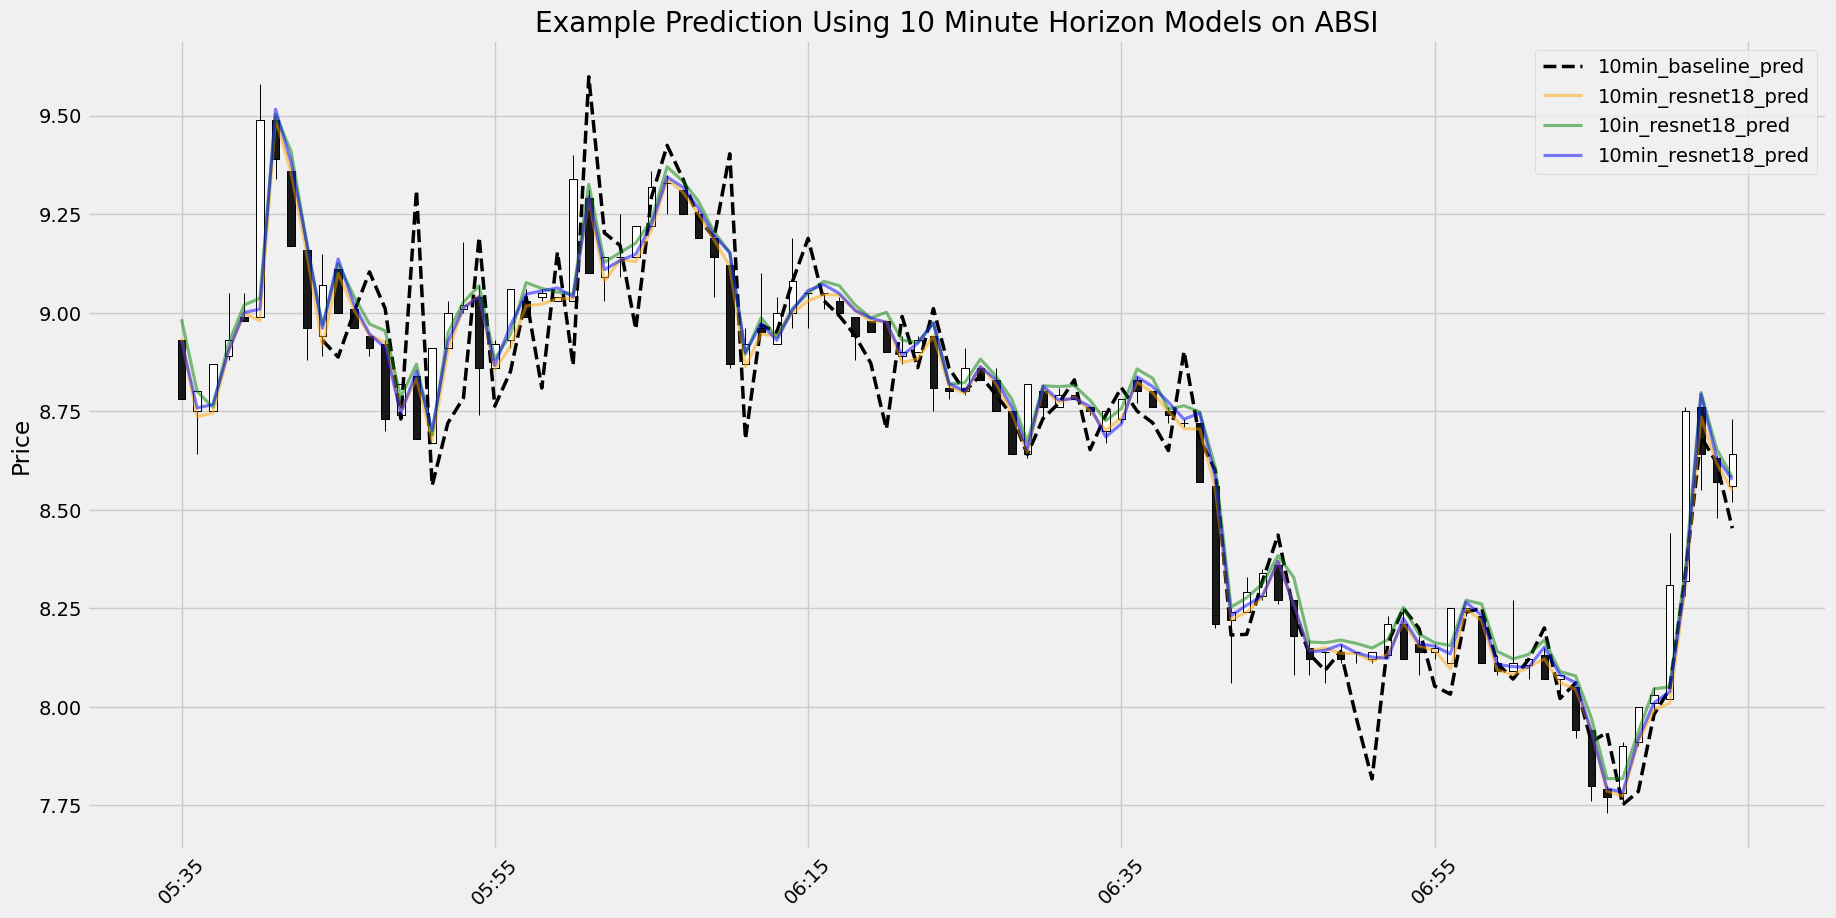

In [25]:
fig, ax = plt.subplots(figsize=(20,10))
mpf.plot(absi, type='candle', ax=ax)
ax.plot(absi['naive10_pred'].values, c='black', linestyle='--', linewidth=2.5, label='10min_baseline_pred')
ax.plot(absi['10min_resnet18_pred'].values, c='orange', alpha=0.5, linewidth=2.25, label='10min_resnet18_pred')
ax.plot(absi['10min_resnet50_pred'].values, c='green', alpha=0.5, linewidth=2.25, label='10in_resnet18_pred')
ax.plot(absi['10min_resnet152_pred'].values, c='blue', alpha=0.5, linewidth=2.25, label='10min_resnet18_pred')
plt.legend()
plt.title('Example Prediction Using 10 Minute Horizon Models on ABSI')
plt.savefig('evaluations/absi_prediction_10min_models.png', dpi=fig.dpi)

In [ ]:
# test_model = LitResnet.load_from_checkpoint(checkpoint_path='model_training_logs/1min_pred/resnet18/sample-mnist-epoch=001-val_loss=0.00000.ckpt', resnet=models.resnet18())
# test_trainer = pl.Trainer()
# results = test_trainer.test(model=test_model, dataloaders=test_loader)

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/